For this colab, I have used datset from Neural information Processing Systems (NIPS) from kaggle Neural Information Processing Systems (NIPS)

## LSH

Finding nearest neighbour from KMeans is not possible for large datsets such as above. So LSH is an alternative for KMeans. Here the datapoints that are similar are placed in a bucket.

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
! pip install datasketch

In [ ]:
import re
import time
from datasketch import MinHash, MinHashLSHForest

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
downloaded = drive.CreateFile({'id':"1dv5C0FHUZiVPbqy0fR_p_5_PHhRC4yjq"})
downloaded.GetContentFile('papers.csv')


In [ ]:
df = pd.read_csv('papers.csv')
df.head()

,id,year,title,event_type,pdf_name,abstract,paper_text
0,1,1987,Self-Organization of Associative Database and ...,NaN,1-self-organization-of-associative-database-an...,Abstract Missing,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...
1,10,1987,A Mean Field Theory of Layer IV of Visual Cort...,NaN,10-a-mean-field-theory-of-layer-iv-of-visual-c...,Abstract Missing,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...
2,100,1988,Storing Covariance by the Associative Long-Ter...,NaN,100-storing-covariance-by-the-associative-long...,Abstract Missing,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...
3,1000,1994,Bayesian Query Construction for Neural Network...,NaN,1000-bayesian-query-construction-for-neural-ne...,Abstract Missing,Bayesian Query Construction for Neural\nNetwor...
4,1001,1994,"Neural Network Ensembles, Cross Validation, an...",NaN,1001-neural-network-ensembles-cross-validation...,Abstract Missing,"Neural Network Ensembles, Cross\nValidation, a..."


In [ ]:
#Number of Permutations
permutations = 128

#Number of Recommendations to return
num_recommendations = 1
## placing similar points in an array
def get_forest(data, perms):
    start_time = time.time()
    
    minhash = []
    
    for text in data['text']:
        tokens = preprocess(text)
        m = MinHash(num_perm=perms)
        for s in tokens:
            m.update(s.encode('utf8'))
        minhash.append(m)
        
    forest = MinHashLSHForest(num_perm=perms)
    
    for i,m in enumerate(minhash):
        forest.add(i,m)
        
    forest.index()
    
    print('It took %s seconds to build forest.' %(time.time()-start_time))
    
    return forest

In [ ]:
# pre-processing of text
def preprocess(text):
    text = re.sub(r'[^\w\s]','',text)
    tokens = text.lower()
    tokens = tokens.split()
    return tokens

text = 'The devil went down to Georgia'
print('The shingles (tokens) are:', preprocess(text))

The shingles (tokens) are: ['the', 'devil', 'went', 'down', 'to', 'georgia']


In [ ]:
## Predicting the points that are in the same bucket
def predict(text, database, perms, num_results, forest):
    start_time = time.time()
    
    tokens = preprocess(text)
    m = MinHash(num_perm=perms)
    for s in tokens:
        m.update(s.encode('utf8'))
        
    idx_array = np.array(forest.query(m, num_results))
    if len(idx_array) == 0:
        return None # if your query is empty, return none
    
    result = database.iloc[idx_array]['title']
    
    print('It took %s seconds to query forest.' %(time.time()-start_time))
    
    return result

In [ ]:
df["text"]=df["title"]+' '+df["abstract"]
df

,id,year,title,event_type,pdf_name,abstract,paper_text,text
0,1,1987,Self-Organization of Associative Database and ...,NaN,1-self-organization-of-associative-database-an...,Abstract Missing,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...,Self-Organization of Associative Database and ...
1,10,1987,A Mean Field Theory of Layer IV of Visual Cort...,NaN,10-a-mean-field-theory-of-layer-iv-of-visual-c...,Abstract Missing,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...,A Mean Field Theory of Layer IV of Visual Cort...
2,100,1988,Storing Covariance by the Associative Long-Ter...,NaN,100-storing-covariance-by-the-associative-long...,Abstract Missing,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...,Storing Covariance by the Associative Long-Ter...
3,1000,1994,Bayesian Query Construction for Neural Network...,NaN,1000-bayesian-query-construction-for-neural-ne...,Abstract Missing,Bayesian Query Construction for Neural\nNetwor...,Bayesian Query Construction for Neural Network...
4,1001,1994,"Neural Network Ensembles, Cross Validation, an...",NaN,1001-neural-network-ensembles-cross-validation...,Abstract Missing,"Neural Network Ensembles, Cross\nValidation, a...","Neural Network Ensembles, Cross Validation, an..."
...,...,...,...,...,...,...,...,...
7236,994,1994,Single Transistor Learning Synapses,NaN,994-single-transistor-learning-synapses.pdf,Abstract Missing,Single Transistor Learning Synapses\n\nPaul Ha...,Single Transistor Learning Synapses Abstract M...
7237,996,1994,"Bias, Variance and the Combination of Least Sq...",NaN,996-bias-variance-and-the-combination-of-least...,Abstract Missing,"Bias, Variance and the Combination of\nLeast S...","Bias, Variance and the Combination of Least Sq..."
7238,997,1994,A Real Time Clustering CMOS Neural Engine,NaN,997-a-real-time-clustering-cmos-neural-engine.pdf,Abstract Missing,A Real Time Clustering CMOS\nNeural Engine\nT....,A Real Time Clustering CMOS Neural Engine Abst...
7239,998,1994,Learning direction in global motion: two class...,NaN,998-learning-direction-in-global-motion-two-cl...,Abstract Missing,Learning direction in global motion: two\nclas...,Learning direction in global motion: two class...


In [ ]:
forest = get_forest(df, permutations)

It took 20.19510841369629 seconds to build forest.


Top 5 recommendation for the author title "Using a neural net to instantiate a deformable model" are as follows:

In [ ]:
num_recommendations = 5
title = 'Using a neural net to instantiate a deformable model'
result = predict(title, df, permutations, num_recommendations, forest)
print('\n Top Recommendation(s) is(are) \n', result)

It took 0.010452032089233398 seconds to query forest.

 Top Recommendation(s) is(are) 
 995     Neural Network Weight Matrix Synthesis Using O...
5       Using a neural net to instantiate a deformable...
5191    A Self-Organizing Integrated Segmentation and ...
2069    Analytic Solutions to the Formation of Feature...
2457    Inferring Neural Firing Rates from Spike Train...
Name: title, dtype: object


### Exhaustive search
In exhustive serach all the similar items are searched in a brute force order and it takes a longer time to find the nearest neighbour.

In [ ]:
df['index'] = df.index


In [ ]:
df

,id,year,title,event_type,pdf_name,abstract,paper_text,text,index
0,1,1987,Self-Organization of Associative Database and ...,NaN,1-self-organization-of-associative-database-an...,Abstract Missing,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...,Self-Organization of Associative Database and ...,0
1,10,1987,A Mean Field Theory of Layer IV of Visual Cort...,NaN,10-a-mean-field-theory-of-layer-iv-of-visual-c...,Abstract Missing,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...,A Mean Field Theory of Layer IV of Visual Cort...,1
2,100,1988,Storing Covariance by the Associative Long-Ter...,NaN,100-storing-covariance-by-the-associative-long...,Abstract Missing,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...,Storing Covariance by the Associative Long-Ter...,2
3,1000,1994,Bayesian Query Construction for Neural Network...,NaN,1000-bayesian-query-construction-for-neural-ne...,Abstract Missing,Bayesian Query Construction for Neural\nNetwor...,Bayesian Query Construction for Neural Network...,3
4,1001,1994,"Neural Network Ensembles, Cross Validation, an...",NaN,1001-neural-network-ensembles-cross-validation...,Abstract Missing,"Neural Network Ensembles, Cross\nValidation, a...","Neural Network Ensembles, Cross Validation, an...",4
...,...,...,...,...,...,...,...,...,...
7236,994,1994,Single Transistor Learning Synapses,NaN,994-single-transistor-learning-synapses.pdf,Abstract Missing,Single Transistor Learning Synapses\n\nPaul Ha...,Single Transistor Learning Synapses Abstract M...,7236
7237,996,1994,"Bias, Variance and the Combination of Least Sq...",NaN,996-bias-variance-and-the-combination-of-least...,Abstract Missing,"Bias, Variance and the Combination of\nLeast S...","Bias, Variance and the Combination of Least Sq...",7237
7238,997,1994,A Real Time Clustering CMOS Neural Engine,NaN,997-a-real-time-clustering-cmos-neural-engine.pdf,Abstract Missing,A Real Time Clustering CMOS\nNeural Engine\nT....,A Real Time Clustering CMOS Neural Engine Abst...,7238
7239,998,1994,Learning direction in global motion: two class...,NaN,998-learning-direction-in-global-motion-two-cl...,Abstract Missing,Learning direction in global motion: two\nclas...,Learning direction in global motion: two class...,7239


In [ ]:
class hashFamily:
    def __init__(self, i):
        self.resultSize = 8 # how many bytes we want back
        self.maxLen = 20 # how long can our i be (in decimal)
        self.salt = str(i).zfill(self.maxLen)[-self.maxLen:]
        
    def get_hash_value(self, el_to_hash):
        return int(hashlib.sha1(str(el_to_hash).encode('utf-8') + self.salt.encode('utf-8')).hexdigest()[-self.resultSize:], 16)

In [ ]:
class shingler:
    def __init__(self, k):
        
        if k > 0:
            self.k = int(k)
        else:
            self.k = 10
        
    #inner class utility
    def process_doc(self, document):
        return re.sub("( )+|(\n)+"," ",document).lower()
    
    def get_shingles(self, document):
        shingles = set()
        document= self.process_doc(document)
        for i in range(0, len(document)-self.k+1 ):
            shingles.add(document[i:i+self.k])
        return shingles
    
    def get_k(self):
        return self.k
    
    #return sorted hash
    def get_hashed_shingles(self, shingles_set):
        hash_function = hashFamily(0)
        return sorted( {hash_function.get_hash_value(s) for s in shingles_set} )

In [ ]:
 class minhashSigner:
    def __init__(self, sig_size):
        self.sig_size=sig_size
        self.hash_functions = [hashFamily(randint(0,10000000000)) for i in range(0,sig_size)]
    
    def compute_set_signature(self, set_):
        set_sig = []
        for h_funct in self.hash_functions:
            min_hash = math.inf
            for el in set_:
                h = h_funct.get_hash_value(el)
                if h < min_hash:
                    min_hash = h
                
            set_sig.append(min_hash)
        
        return set_sig
    
    #return a list of lists that can be seen as the signature matrix
    def compute_signature_matrix(self, set_list):
        signatures = []
        for s in set_list:
            signatures.append( self.compute_set_signature(s) )
            
        return signatures

In [ ]:
class bfsc():
    def compare_shingles_set_js(self, set1, set2):
        return len(set1.intersection(set2))/len(set1.union(set2))

In [ ]:
import pandas as pd
import re, hashlib, math, time
from random import randint, seed
print("Loading dataset...")
dataset=df
dataset['doc_id']=dataset.index
doc_nr = dataset['doc_id'].max()
print("Dataset loaded correctly.")
print("Producing Shingles...")
start_time = time.time()
#an array where the index i represent the document_id and the element shingling_list[i] the hashed shingles for document document_id
shingling_list = [None] * (doc_nr +1) 
shingling_size = 10
signature_size = 50
bands_nr = 10

shingler_inst = shingler(shingling_size)
signer = minhashSigner(signature_size)


#produce hashed shinglings for all documents
for index, row in dataset.iterrows():
    doc = row['title']+" "+row['abstract']
    i = row['doc_id']
    
    shinglings = shingler_inst.get_hashed_shingles( shingler_inst.get_shingles(doc) )
    shingling_list[i] = shinglings

end_time = time.time()
print("Shingles produced in:\t %.2f seconds."%(end_time - start_time))


start_time = time.time()
print("Computing signature matrix...")
#produce a signature for each shingle set
signature_matrix = signer.compute_signature_matrix( shingling_list )
end_time = time.time()
print("Signature Matrix computed in:\t %.2f seconds." %(end_time - start_time))

Loading dataset...
Dataset loaded correctly.
Producing Shingles...
Shingles produced in:	 12.02 seconds.
Computing signature matrix...
Signature Matrix computed in:	 377.55 seconds.


In [ ]:
brute_force_comparer = bfsc()
brute_force_similar_items = set()
start_time = time.time()
false_positive = 0

In [ ]:
for i in range(0,doc_nr-1):
    for j in range(i+1,doc_nr):
        similarity = brute_force_comparer.compare_shingles_set_js(set(shingling_list[i]),set(shingling_list[j]))
        if similarity >= 0.8:
            brute_force_similar_items.add( (i,j) ) 
            
end_time = time.time()
bf_computation_time = end_time - start_time

The computation time is 80% higher than the LSH.

In [ ]:
print("exhaustive search computation time",bf_computation_time )

exhaustive search computation time 2656.1900131702423


Text that is similar to Documnet1 are

In [ ]:
for i in range(0,3):
    docs = brute_force_similar_items.pop()
    print("Doc 1:")
    print(dataset.iloc[docs[0]] )
    print("Is similar to\nDoc2:")
    print(dataset.iloc[docs[1]] )

Doc 1:
id                                                         5918
year                                                       2015
title           Convergence rates of sub-sampled Newton methods
event_type                                               Poster
pdf_name      5918-convergence-rates-of-sub-sampled-newton-m...
abstract      An active learner is given a class of models, ...
paper_text    Convergence rates of sub-sampled Newton method...
text          Convergence rates of sub-sampled Newton method...
index                                                      5433
doc_id                                                     5433
Name: 5433, dtype: object
Is similar to
Doc2:
id                                                         5921
year                                                       2015
title         Convergence Rates of Active Learning for Maxim...
event_type                                               Poster
pdf_name      5921-convergence-rates-of-active-lear

### Product quantization
After the dimensionality reduction the nearset neighbour is searched

In [ ]:
pip install lightfm

     |████████████████████████████████| 310 kB 5.1 MB/s 
  Created wheel for lightfm: filename=lightfm-1.16-cp37-cp37m-linux_x86_64.whl size=705372 sha256=4a835a40269cc80a479dbdd031eeb618bdbc217eddb1fb32f8bda9738ddef23a
  Stored in directory: /root/.cache/pip/wheels/f8/56/28/5772a3bd3413d65f03aa452190b00898b680b10028a1021914
Successfully built lightfm


In [ ]:
import pandas as pd
import seaborn as sns
import scipy
import numpy as np
from lightfm import LightFM
from lightfm.evaluation import precision_at_k,auc_score

In [ ]:
ratings=pd.read_csv('/content/drive/MyDrive/DataMining/Assignmnet3/dataset/ratings.csv')
books=pd.read_csv('/content/drive/MyDrive/DataMining/Assignmnet3/dataset/books.csv')

In [ ]:
ratings[['book_id','user_id']].duplicated().sum()

2278

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


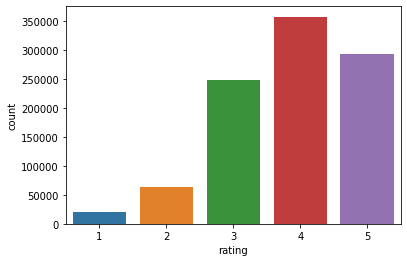

In [ ]:
sns.countplot('rating',data=ratings)

In [ ]:
books['original_title']

0                                        The Hunger Games
1                Harry Potter and the Philosopher's Stone
2                                                Twilight
3                                   To Kill a Mockingbird
4                                        The Great Gatsby
                              ...                        
9995                                           Bayou Moon
9996                                     Means of Ascent 
9997                                The Mauritius Command
9998    Cinderella Ate My Daughter: Dispatches from th...
9999                                  The First World War
Name: original_title, Length: 10000, dtype: object

In [ ]:
train_data=ratings.pivot_table(values='rating',index='user_id',columns='book_id')
train_data=train_data.fillna(0)
print(train_data.shape)

(53424, 10000)


In [ ]:
train_data=scipy.sparse.csr_matrix(train_data.values)

In [ ]:
model = LightFM(learning_rate=0.05,loss='warp')
model.fit(train_data, epochs=30, num_threads=8)

In [ ]:
train_precision = precision_at_k(model, train_data, k=5).mean()
train_auc = auc_score(model, train_data).mean()

print('Precision: train %.2f' % (train_precision))
print('AUC: train %.2f' % (train_auc))

Precision: train 0.20
AUC: train 0.97


Product quantization provides better accuracy when compared to LSH

In [ ]:
def recommendation_sys(model,data,user_ids):
    """
    Function to ouput recommendation for random users  
    """
    n_users, n_items = data.shape
    for user_id in user_ids:
        #know positive
        kp=books['original_title'][data[user_id].indices]
        score=model.predict(int(user_id),np.arange(n_items))
        top_items=books['original_title'][np.argsort(-score)]
        #print out the results
        print("User %s" % user_id)
        print("     Known positives:")
        for x in kp[:3]:
            print("        %s" % x)
        print("     Recommended:")
        for x in top_items[:3]:
            print("        %s" % x)
            
recommendation_sys(model, train_data, np.random.randint(1000,size=3))

User 477
     Known positives:
        Aftermath
        nan
        nan
     Recommended:
        nan
        nan
        nan
User 566
     Known positives:
        Out of My Mind
        Moonwalking with Einstein: The Art and Science of Remembering Everything
        Son (The Giver, #4)
     Recommended:
        Small Island
        Behind the Scenes at the Museum
        Counting by 7s
User 68
     Known positives:
        A Universe from Nothing: Why There Is Something Rather Than Nothing
        Leviathan
        nan
     Recommended:
        nan
        The Psychology of Everyday Things
        Le capital au XXIe siècle 


## Trees

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style("whitegrid")
plt.style.use("fivethirtyeight")

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/DataMining/Assignmnet3/dataset/WA_Fn-UseC_-HR-Employee-Attrition.csv")
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2


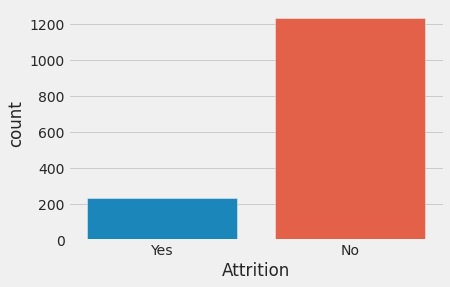

In [ ]:
sns.countplot(x='Attrition', data=df)

In [ ]:
df.drop(['EmployeeCount', 'EmployeeNumber', 'Over18', 'StandardHours'], axis="columns", inplace=True)

categorical_col = []
for column in df.columns:
    if df[column].dtype == object and len(df[column].unique()) <= 50:
        categorical_col.append(column)
        
df['Attrition'] = df.Attrition.astype("category").cat.codes

In [ ]:
categorical_col.remove('Attrition')

In [ ]:
from sklearn.preprocessing import LabelEncoder

label = LabelEncoder()
for column in categorical_col:
    df[column] = label.fit_transform(df[column])

In [ ]:
from sklearn.model_selection import train_test_split

X = df.drop('Attrition', axis=1)
y = df.Attrition

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    if train:
        pred = clf.predict(X_train)
        clf_report = pd.DataFrame(classification_report(y_train, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, pred)}\n")
        
    elif train==False:
        pred = clf.predict(X_test)
        clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")

In [ ]:
from sklearn.tree import DecisionTreeClassifier

tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)

print_score(tree_clf, X_train, y_train, X_test, y_test, train=True)
print_score(tree_clf, X_train, y_train, X_test, y_test, train=False)

Train Result:
Accuracy Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
               0      1  accuracy  macro avg  weighted avg
precision    1.0    1.0       1.0        1.0           1.0
recall       1.0    1.0       1.0        1.0           1.0
f1-score     1.0    1.0       1.0        1.0           1.0
support    853.0  176.0       1.0     1029.0        1029.0
_______________________________________________
Confusion Matrix: 
 [[853   0]
 [  0 176]]

Test Result:
Accuracy Score: 77.78%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.887363   0.259740  0.777778    0.573551      0.800549
recall       0.850000   0.327869  0.777778    0.588934      0.777778
f1-score     0.868280   0.289855  0.777778    0.579067      0.788271
support    380.000000  61.000000  0.777778  441.000000    441.000000
_______________________________________________
Conf

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

params = {
    "criterion":("gini", "entropy"), 
    "splitter":("best", "random"), 
    "max_depth":(list(range(1, 20))), 
    "min_samples_split":[2, 3, 4], 
    "min_samples_leaf":list(range(1, 20)), 
}


tree_clf = DecisionTreeClassifier(random_state=42)
tree_cv = GridSearchCV(tree_clf, params, scoring="accuracy", n_jobs=-1, verbose=1, cv=3)
tree_cv.fit(X_train, y_train)
best_params = tree_cv.best_params_
print(f"Best paramters: {best_params})")

tree_clf = DecisionTreeClassifier(**best_params)
tree_clf.fit(X_train, y_train)
print_score(tree_clf, X_train, y_train, X_test, y_test, train=True)
print_score(tree_clf, X_train, y_train, X_test, y_test, train=False)

Fitting 3 folds for each of 4332 candidates, totalling 12996 fits
Best paramters: {'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 10, 'min_samples_split': 2, 'splitter': 'best'})
Train Result:
Accuracy Score: 88.82%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy    macro avg  weighted avg
precision    0.906388    0.752066  0.888241     0.829227      0.879993
recall       0.964830    0.517045  0.888241     0.740938      0.888241
f1-score     0.934696    0.612795  0.888241     0.773745      0.879638
support    853.000000  176.000000  0.888241  1029.000000   1029.000000
_______________________________________________
Confusion Matrix: 
 [[823  30]
 [ 85  91]]

Test Result:
Accuracy Score: 84.35%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.887781   0.400000  0.843537    0.643890      0.820310
recall  

In [ ]:
from IPython.display import Image
from six import StringIO
from sklearn.tree import export_graphviz
import pydot

features = list(df.columns)
features.remove("Attrition")

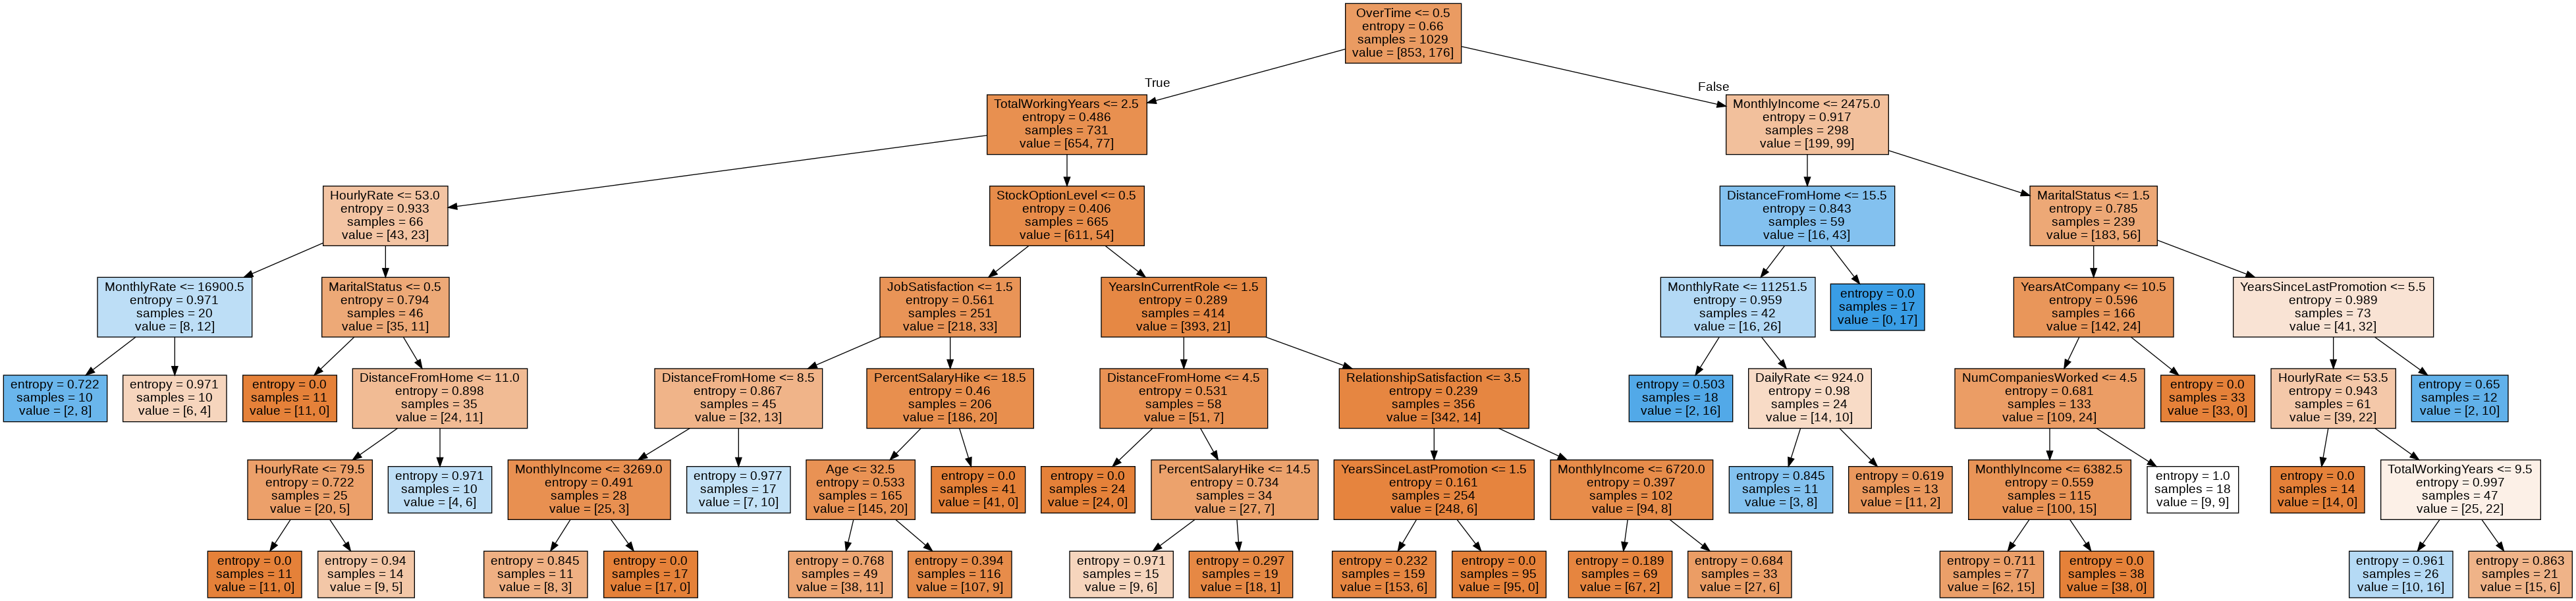

In [ ]:
dot_data = StringIO()
export_graphviz(tree_clf, out_file=dot_data, feature_names=features, filled=True)
graph = pydot.graph_from_dot_data(dot_data.getvalue())
Image(graph[0].create_png())

The tree structure provides easy wasy to search the product based on BFS and DFS algorithms. Trees provide an efficiency of 83%

## Forest
Forest consists of multiple trees

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=100)
rf_clf.fit(X_train, y_train)

print_score(rf_clf, X_train, y_train, X_test, y_test, train=True)
print_score(rf_clf, X_train, y_train, X_test, y_test, train=False)

Train Result:
Accuracy Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
               0      1  accuracy  macro avg  weighted avg
precision    1.0    1.0       1.0        1.0           1.0
recall       1.0    1.0       1.0        1.0           1.0
f1-score     1.0    1.0       1.0        1.0           1.0
support    853.0  176.0       1.0     1029.0        1029.0
_______________________________________________
Confusion Matrix: 
 [[853   0]
 [  0 176]]

Test Result:
Accuracy Score: 86.85%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.872685   0.666667  0.868481    0.769676      0.844188
recall       0.992105   0.098361  0.868481    0.545233      0.868481
f1-score     0.928571   0.171429  0.868481    0.550000      0.823842
support    380.000000  61.000000  0.868481  441.000000    441.000000
_______________________________________________
Conf

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start=200, stop=2000, num=10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators, 'max_features': max_features,
               'max_depth': max_depth, 'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf, 'bootstrap': bootstrap}

rf_clf = RandomForestClassifier(random_state=42)

rf_cv = RandomizedSearchCV(estimator=rf_clf, scoring='f1',param_distributions=random_grid, n_iter=100, cv=3, 
                               verbose=2, random_state=42, n_jobs=-1)

rf_cv.fit(X_train, y_train)
rf_best_params = rf_cv.best_params_
print(f"Best paramters: {rf_best_params})")

rf_clf = RandomForestClassifier(**rf_best_params)
rf_clf.fit(X_train, y_train)

print_score(rf_clf, X_train, y_train, X_test, y_test, train=True)
print_score(rf_clf, X_train, y_train, X_test, y_test, train=False)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best paramters: {'n_estimators': 400, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 90, 'bootstrap': False})
Train Result:
Accuracy Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
               0      1  accuracy  macro avg  weighted avg
precision    1.0    1.0       1.0        1.0           1.0
recall       1.0    1.0       1.0        1.0           1.0
f1-score     1.0    1.0       1.0        1.0           1.0
support    853.0  176.0       1.0     1029.0        1029.0
_______________________________________________
Confusion Matrix: 
 [[853   0]
 [  0 176]]

Test Result:
Accuracy Score: 86.39%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.872093   0.545455  0.863946    0.708774      0.826912
recall       0.986842   0.098361  0.863946    0.5

Forest provides an efficiency of 86%

### HNSW
Hierarchical Navigable Small World graphs uses small word graphs in a hirerachy to as an alternate to K-Means

In [ ]:
!pip install hnswlib

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from functools import reduce
from tqdm.notebook import tqdm

import torch, torch.nn as nn
from torchtext.vocab import FastText
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence
from fastai.text import Tokenizer, Vocab

import hnswlib

In [ ]:
df_paper=df

In [ ]:
df_paper.head()


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2


In [ ]:
df_paper_selected=df_paper[["Age", "DistanceFromHome", "EnvironmentSatisfaction", "MonthlyIncome", "JobSatisfaction", "MonthlyRate"]]
len(df_paper_selected)

1470

In [ ]:
df_paper_selected.isna().sum()

Age                        0
DistanceFromHome           0
EnvironmentSatisfaction    0
MonthlyIncome              0
JobSatisfaction            0
MonthlyRate                0
dtype: int64

In [ ]:
pip install nmslib


     |████████████████████████████████| 13.5 MB 83 kB/s 
     |████████████████████████████████| 188 kB 38.9 MB/s 


In [ ]:
import nmslib
index = nmslib.init(method='hnsw', space='cosinesimil')

In [ ]:
index.addDataPointBatch(df_paper_selected)


1470

In [ ]:
index.createIndex({'post': 2}, print_progress=True)

In [ ]:
ids, distances = index.knnQuery(df_paper_selected, k=10)

[ 627  641  976 1199 1200 1313 1448  289  341  434] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
neighbours = index.knnQueryBatch(df_paper_selected, k=10, num_threads=4)

In [ ]:
neighbours

[(array([   0,   51,  522, 1300,  145,  274, 1044,  874, 1228,  517], dtype=int32),
  array([0.000000e+00, 1.192093e-07, 2.384186e-07, 2.384186e-07, 4.172325e-07, 4.768372e-07, 5.960464e-07, 6.556511e-07,
         9.536743e-07, 1.430511e-06], dtype=float32)),
 (array([   1,  923,   94,  444,  629,  687,  144,  847,  959, 1071], dtype=int32),
  array([5.960464e-08, 1.788139e-07, 2.384186e-07, 2.384186e-07, 3.576279e-07, 9.536743e-07, 1.013279e-06, 1.251698e-06,
         1.311302e-06, 1.311302e-06], dtype=float32)),
 (array([   2, 1389,  484,  494,  304, 1387, 1290,  119, 1009,   77], dtype=int32),
  array([0.000000e+00, 3.409386e-05, 3.695488e-05, 3.707409e-05, 4.726648e-05, 4.744530e-05, 4.887581e-05, 5.161762e-05,
         5.227327e-05, 5.245209e-05], dtype=float32)),
 (array([   3,  236, 1428,  419,  388, 1202, 1390,  580,  474, 1069], dtype=int32),
  array([0.000000e+00, 0.000000e+00, 5.960464e-08, 5.960464e-08, 1.192093e-07, 2.384186e-07, 3.576279e-07, 4.768372e-07,
         5.3644

Provides top-10 neighbours for our dataset